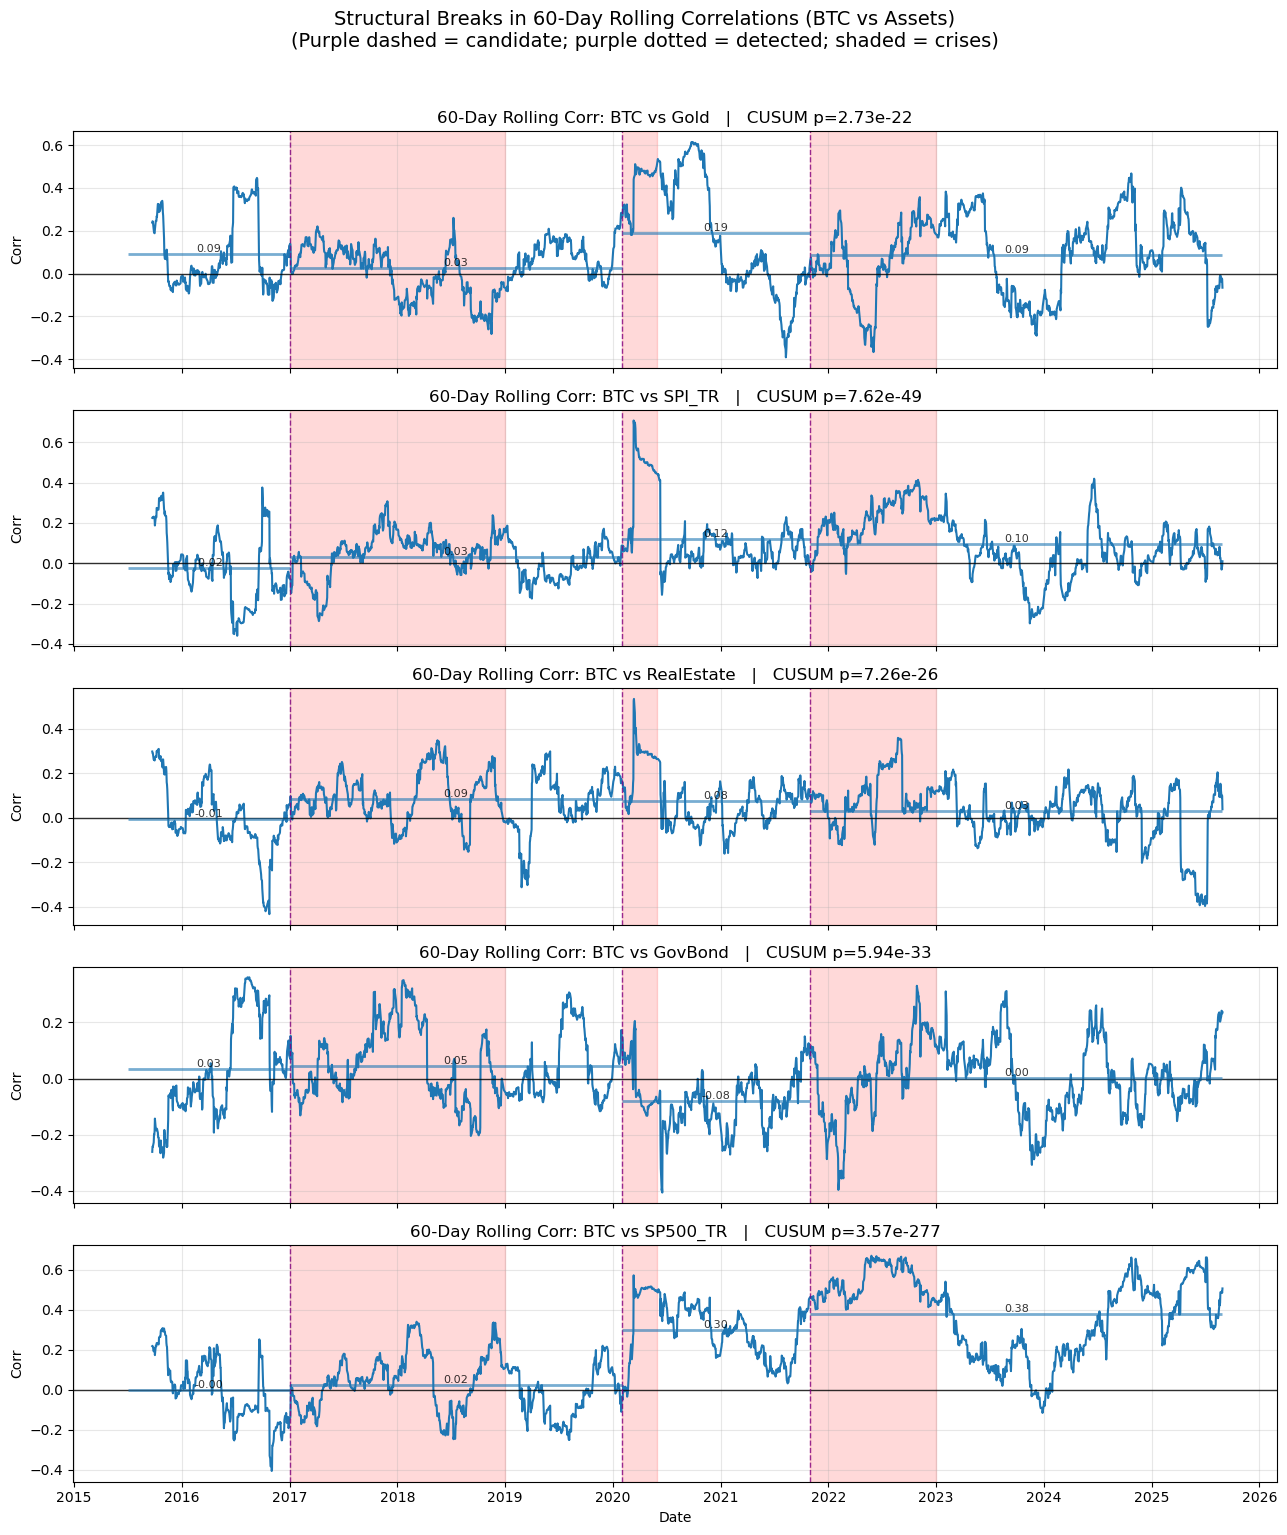

✅ Saved figure and summary CSV:
    C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit\RollingCorr_60D_BTC_Subplots_Breaks.png
    C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit\RollingCorr_60D_BTC_SubperiodMeans_and_CUSUM.csv


In [4]:
# ===========================
# Structural breaks on rolling correlations (60D)
# ===========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.stats.diagnostic import breaks_cusumolsresid

# Try optional data-driven break detection
try:
    import ruptures as rpt
    HAS_RUPTURES = True
except Exception:
    HAS_RUPTURES = False

# ---------- 1) Load rolling correlations ----------
base = r"C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit"
roll_path = fr"{base}\RollingCorrelations_BTC_60D.xlsx"
rolling_corrs = pd.read_excel(roll_path, index_col=0, parse_dates=True)
assets = list(rolling_corrs.columns)

# ---------- 2) Define crisis/event windows + candidate breaks ----------
crisis_periods = [
    ("2017-01-01", "2018-12-31", "2017–18 Crypto Bubble"),
    ("2020-02-01", "2020-05-31", "Covid-19 Crash"),
    ("2021-11-01", "2022-12-31", "2021–22 Crypto Winter"),
]
candidate_breaks = pd.to_datetime([
    "2017-01-01",
    "2020-02-01",
    "2021-11-01",
])
candidate_breaks = [d for d in candidate_breaks
                    if rolling_corrs.index.min() < d < rolling_corrs.index.max()]

# ---------- 3) Detect breaks (optional if ruptures installed) ----------
def detect_breaks_with_ruptures(y: pd.Series, n_bkps: int = 3):
    if not HAS_RUPTURES:
        return []
    z = y.dropna().values
    if len(z) < 200:
        return []
    algo = rpt.Binseg(model="l2").fit(z)
    bkp_idx = algo.predict(n_bkps=n_bkps)
    idx = y.dropna().index
    ts = []
    for i in bkp_idx[:-1]:
        if 1 <= i < len(idx):
            ts.append(idx[i])
    ts = sorted(pd.to_datetime(list(set(ts))))
    return ts

# ---------- 4) Fixed CUSUM helper ----------
def cusum_pvalue(y: pd.Series):
    """
    CUSUM stability test on the mean of the rolling-correlation series.
    Returns p-value; small p (<0.05) => reject stability (breaks likely).
    """
    z = y.dropna().values
    if z.size < 100:
        return np.nan
    X = np.ones((z.size, 1))
    resid = sm.OLS(z, X).fit().resid
    res = breaks_cusumolsresid(resid)
    pval = float(res[1]) if isinstance(res, (list, tuple)) and len(res) > 1 else np.nan
    return pval

# ---------- 5) Plot per-asset with breaks + sub-period means ----------
summary_rows = []
fig, axes = plt.subplots(len(assets), 1, figsize=(13, 3 * len(assets)), sharex=True)

for ax, col in zip(axes, assets):
    y = rolling_corrs[col].copy()

    # Plot rolling correlation
    ax.plot(y.index, y.values, label=f'BTC vs {col}', color='tab:blue')
    ax.axhline(0, color='black', lw=1, alpha=0.8)

    # Shade crisis periods
    for start, end, label in crisis_periods:
        ax.axvspan(pd.to_datetime(start), pd.to_datetime(end),
                   color='red', alpha=0.15)

    # Compute CUSUM p-value
    pval = cusum_pvalue(y)
    ptext = f"{pval:.3g}" if np.isfinite(pval) else "n/a"
    ax.set_title(f"60-Day Rolling Corr: BTC vs {col}   |   CUSUM p={ptext}")

    # Detect additional breaks (if ruptures installed)
    detected_breaks = detect_breaks_with_ruptures(y, n_bkps=3)
    all_breaks = sorted(pd.to_datetime(list(set(detected_breaks + candidate_breaks))))
    all_breaks = [d for d in all_breaks if (y.index.min() < d < y.index.max())]

    # Draw break lines
    for d in all_breaks:
        style = '--' if d in candidate_breaks else ':'
        ax.axvline(d, color='purple', linestyle=style, alpha=0.8, lw=1)

    # Draw sub-period mean correlations
    segment_edges = [y.index.min()] + all_breaks + [y.index.max()]
    segment_edges = sorted(pd.to_datetime(pd.unique(segment_edges)))

    for i in range(len(segment_edges) - 1):
        start = segment_edges[i]
        end = segment_edges[i + 1]
        seg = y.loc[(y.index >= start) & (y.index <= end)]
        if len(seg) < 5:
            continue
        m = seg.mean()
        ax.hlines(m, xmin=start, xmax=end, colors='tab:blue', lw=2, alpha=0.6)
        ax.text(start + (end - start) / 2, m, f"{m:.2f}",
                ha='center', va='bottom', fontsize=8, alpha=0.8)
        summary_rows.append({
            "Pair": f"BTC vs {col}",
            "SegmentStart": start.date(),
            "SegmentEnd": end.date(),
            "Observations": int(seg.notna().sum()),
            "MeanCorr": round(float(m), 4),
            "CUSUM_p": None if np.isnan(pval) else float(pval),
            "BreakType": "candidate/detected mix"
        })

    ax.set_ylabel('Corr')
    ax.grid(alpha=0.3)

# Format x-axis
axes[-1].set_xlabel('Date')
for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle('Structural Breaks in 60-Day Rolling Correlations (BTC vs Assets)\n'
             '(Purple dashed = candidate; purple dotted = detected; shaded = crises)',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ---------- 6) Save figure and summary ----------
fig.savefig(fr"{base}\RollingCorr_60D_BTC_Subplots_Breaks.png", dpi=300, bbox_inches='tight')

summary_df = pd.DataFrame(summary_rows)
summary_csv = fr"{base}\RollingCorr_60D_BTC_SubperiodMeans_and_CUSUM.csv"
summary_df.to_csv(summary_csv, index=False)
print("✅ Saved figure and summary CSV:")
print("   ", fr"{base}\RollingCorr_60D_BTC_Subplots_Breaks.png")
print("   ", summary_csv)
